<a href="https://colab.research.google.com/github/SanjayS45/Pneumonia-Detection/blob/main/Copy_of_Student_PneumoniaDetection_Section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

In this notebook, we'll try out our model on field data - data outside our normal testing and training data! We'll also learn techniques for data augmentation, creating new "fake data" so that our model can generalize more effectively.

In this notebook we'll be:
1.   Putting our ML models into practice
2.   Improving our ML models



In [3]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
# %tensorflow_version 1.x
import random

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    rand = random.uniform(-1, 1)

    for i in range(len(field_data)):
      image = field_data[i]

      if abs(rand) < 0.5:
        image = rotate(image, rotate = rand * 40)
      elif abs(rand) < 0.8:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.legacy.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(64, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0s      
image_data.npy.1    100%[===================>] 131.25M  22.5MB/s    in 6.7s    


# Milestone 1: Putting our model into practice

## Activity 1a: Testing on Field Data
#### While your models may have done well on your original training and validation data, deploying the model on "field" data can present different challenges. Field data is data that is different from the one where you built your model. For e.g. images obtained from a different x-ray machine.

### Exercise (Coding)

Yesterday we worked with CNNs, which we saw perform much better than multi-layer perceptrons on imaging data.

Below, please **re-train a 2-layer CNN and plot its accuracy over time!** (You can use all the functions from yesterday's code.) You can choose the number of epochs based on the graph.

Epoch 1/20
63/63 [==============================] - 10s 19ms/step - loss: 2.6580 - accuracy: 0.5005 - val_loss: 2.6391 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2.6232 - accuracy: 0.5315 - val_loss: 2.6075 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.5934 - accuracy: 0.5170 - val_loss: 2.5768 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 2.5621 - accuracy: 0.5430 - val_loss: 2.5458 - val_accuracy: 0.5000
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 2.5323 - accuracy: 0.5545 - val_loss: 2.5153 - val_accuracy: 0.5000
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 2.5016 - accuracy: 0.5680 - val_loss: 2.4853 - val_accuracy: 0.5100
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 2.4711 - accuracy: 0.5790 - val_loss: 2.4560 - val_accuracy: 0.5300
Epoch 8/20
63/63

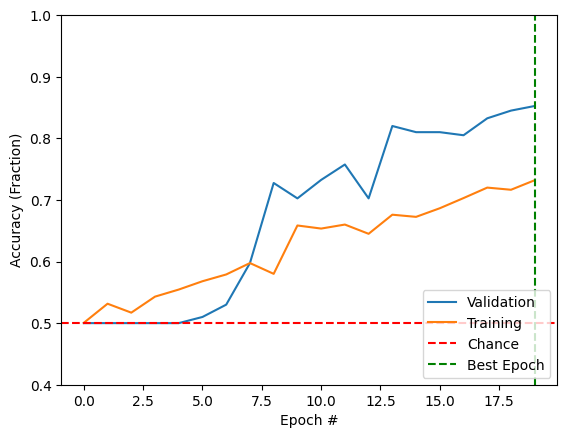

In [4]:
train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()

### YOUR CODE HERE
model_CNN = CNNClassifier(num_hidden_layers = 3)
hist = model_CNN.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))
pred = model_CNN.predict(test_data)

plot_acc(hist)

### END CODE

### Exercise (Coding)

Our radiologist friends have provided us with some new data from the field. We can access this with `get_field_data()`.

Please create **field_data** and **field_labels**.

In [5]:
#YOUR CODE HERE
field_data, field_labels = get_field_data()

What accuracy do you get when you use your trained CNN on the field data? Please calculate it below (hint: `.predict(field_data) > 0.5`)

In [6]:
#YOUR CODE HERE
field_preds = model_CNN.predict(field_data) > 0.5
accuracy_score(field_preds, field_labels)

13/13 [==============================] - 0s 2ms/step


0.79

**Discuss:** How does your performance on field data compare to test and train data?

You've probably noticed that you get different performance every time you train your model! Let's get a sense of the average: below, please **train your model 5 times, calculate the accuracy on the field data each time, and print the average accuracy.**

In [7]:
### YOUR CODE HERE
sum = 0
for i in range(5):
  model_CNN = CNNClassifier(num_hidden_layers = 3)
  hist = model_CNN.fit(train_data, train_labels, epochs=20, validation_data=(field_data, field_labels))
  field_preds = model_CNN.predict(field_data) > 0.5
  accuracy_score(field_preds, field_labels)
  field_preds = model_CNN.predict(field_data) > 0.5
  sum += accuracy_score(field_preds, field_labels)
print(sum/5)

### END CODE

Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 2.6446 - accuracy: 0.5275 - val_loss: 2.6288 - val_accuracy: 0.5125
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 2.6160 - accuracy: 0.5350 - val_loss: 2.5985 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 2.5835 - accuracy: 0.5680 - val_loss: 2.5692 - val_accuracy: 0.5325
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2.5539 - accuracy: 0.5855 - val_loss: 2.5411 - val_accuracy: 0.5850
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 2.5232 - accuracy: 0.5960 - val_loss: 2.5129 - val_accuracy: 0.6150
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 2.4925 - accuracy: 0.6205 - val_loss: 2.4851 - val_accuracy: 0.7000
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 2.4653 - accuracy: 0.6280 - val_loss: 2.4569 - val_accuracy: 0.6175
Epoch 8/20
63/63 [=

## Activity 1b: Understanding our model's performance on field data

### Exercise (Discussion)
Discuss this with your instructor:
* How did your model do? Did it perform quite as well?
* Why do you think it did this way?
* **Come up with a few hypotheses for what's different between our test data and our field data!**

## Activity 1c: Error analysis

### Understanding where the model did not perform as well

### Exercise (Coding)

Since our `field_data` comes from the field, it's possible that it's different from `train_data` and `test_data` in some important ways!

Let's compare a few images. Below, please use a `for` loop and `plot_one_image(data, labels, index)` to print out a few images from the different datasets.

**Do you notice any differences in the datasets?**




Label: 1.0


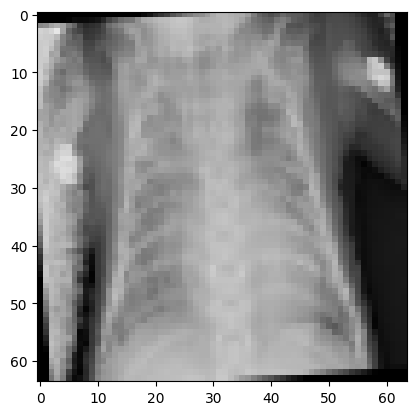

Label: 0.0


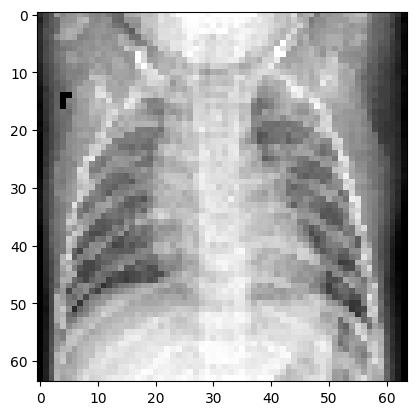

Label: 1.0


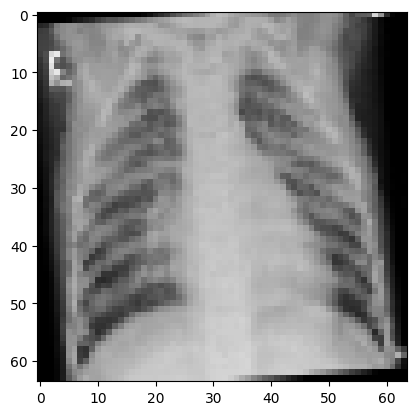

Label: 0.0


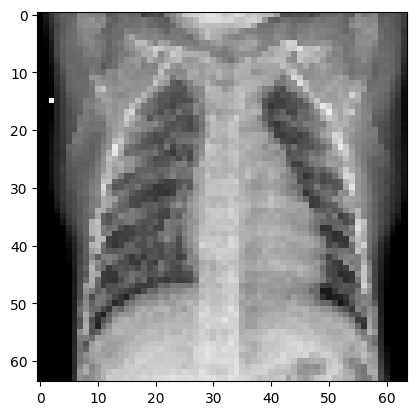

Label: 0.0


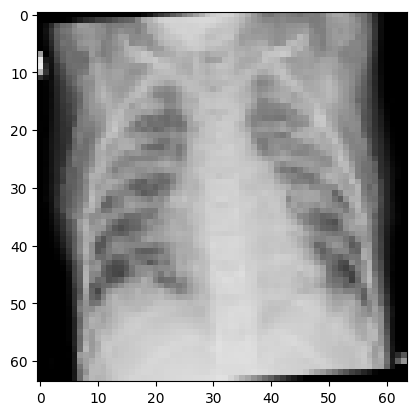

Label: 1.0


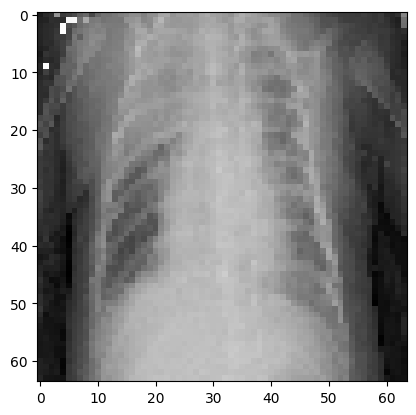

Label: 0.0


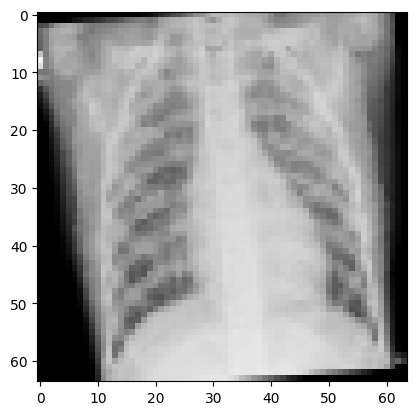

Label: 0.0


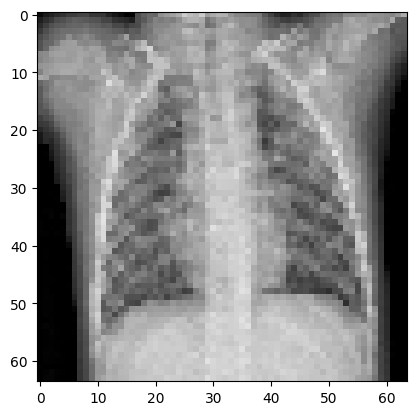

Label: 0.0


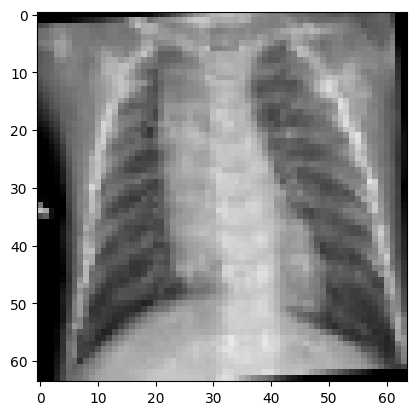

Label: 1.0


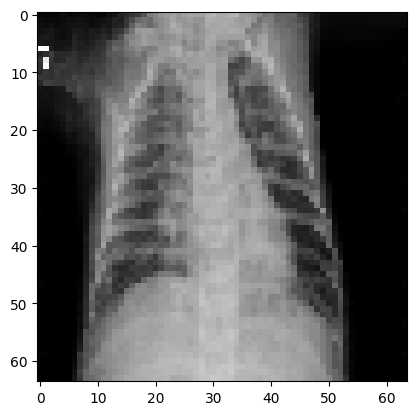

In [8]:
#YOUR CODE HERE
for i in range(5):
  plot_one_image(field_data, field_labels, i)
  plot_one_image(train_data, train_labels, i)


### END CODE

## Instructor-Led Discussion: What is happening in our field data?

Discuss in your group and with your instructor:

Why is our model performance suffering? What are reasons that field data could be "messier"?

# Milestone 2: Tools to improve your models

## Activity 2a

### Instructor-Led Discussion: Data Augmentation

We want our model to handle a broader variety of input data. One way to do this is to **augment** our data: by intentionally making some alterations to our input data, we can train our model to handle a greater variety of outputs.

### Exercise (Coding)

So, how do we augment our images in Python?


We provide custom functions for augmenting a single image. Here's one example, to rotate a single image by 40 degrees. **Experiment with changing the degrees! How can you rotate left?**

Label: 


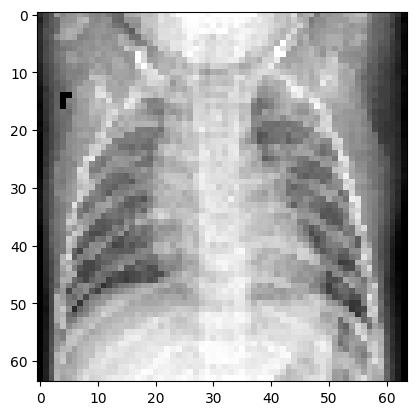

Label: 


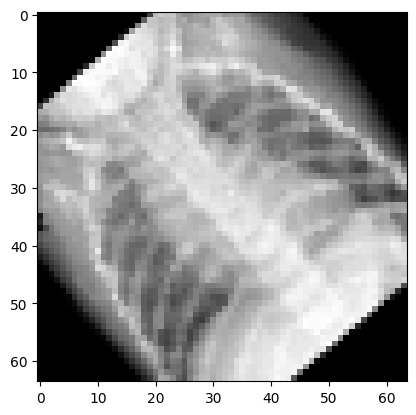

In [9]:
image = train_data[0]
plot_one_image(image)
new_image = rotate(image, rotate = -40)
plot_one_image(new_image)


Here's some more image transformation options:
* `rotate(image, rotate = 30)`
* `scale(image, scale = 1.5)`
* `shear(image, shear = 20)`
* `flip_left_right(image, prob = 0.5)`
* `flip_up_down(image, prob = 0.5)`
* `remove_color(image, channel = 0)`

Try it out below!

Label: 


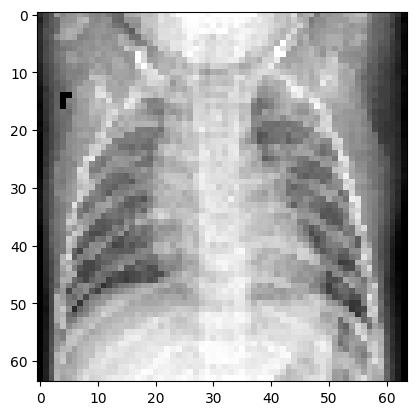

Label: 


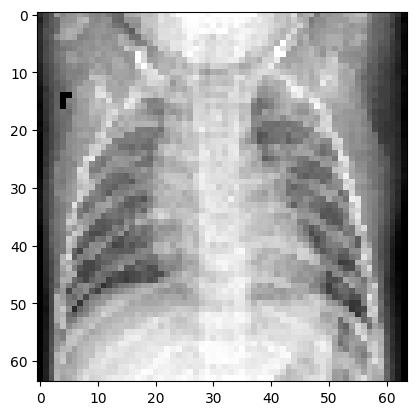

In [10]:
#YOUR CODE HERE
new_image = rotate(image, rotate = 20)
another_image = scale(image, scale=2)
image_2 = shear(image, shear= 50)
flip_image = flip_up_down(image, prob = 0.6)
plot_one_image(image)
plot_one_image(flip_image)

Now, experiment with these options!

**Share some of your cool augmentation strategies with the class! You can definitely use multiple augmentation techniques for each image!**

In [11]:
### YOUR CODE HERE

### END CODE

## Activity 2b.

### Exercise (Coding)

Now, let's create some augmented datasets of our own! We'll combine the augmented data with the original. Here's how you make an augmented dataset:

In [12]:
train_data_rotated_10 = rotate(train_data, rotate=10)
train_labels_new = rotate(train_data, rotate=10)

Please make some more augmented datasets below!

In [13]:
###YOUR CODE HERE to create more augmented datasets




Finally, to combine your original train data with your augmented data, you can use the `combine_data` function like this:
```
all_data, all_labels = combine_data([data1, data2], [labels1, labels2])
```

(You can include as many datasets as you like in the list. What should you use for the new labels?)

Please create `all_data` and `all_labels` below:

In [14]:
#YOUR CODE HERE
all_data, all_labels = combine_data([train_data_rotated_10, train_data], [train_labels, train_labels])
### END CODE

Once you've created your augmented data...
1. Train your CNN on `all_data`
2. Choose the best epoch based on the `test_data`
3. Load your model up and score it on `field_data`

**Your challenge is to find a set of augmentations that improves your model's performance on the `field_data`! Share your augmentations and performances with the class! Try as many or as few augmentations as you want.**

**Remember to record an average of 5 newly initialized CNNs. This is important because CNN weights will be initialized differently in each run!**

Epoch 1/20
125/125 [==============================] - 3s 10ms/step - loss: 3.9035 - accuracy: 0.4963 - val_loss: 3.8437 - val_accuracy: 0.5000
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 3.7874 - accuracy: 0.5228 - val_loss: 3.7319 - val_accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 3.6776 - accuracy: 0.5165 - val_loss: 3.6239 - val_accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 3.5717 - accuracy: 0.5157 - val_loss: 3.5177 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 3.4664 - accuracy: 0.5232 - val_loss: 3.4148 - val_accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 3.3652 - accuracy: 0.5462 - val_loss: 3.3152 - val_accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 1s 9ms/step - loss: 3.2676 - accuracy: 0.5462 - val_loss: 3.2194 - val_accuracy: 0.5000
Epoch

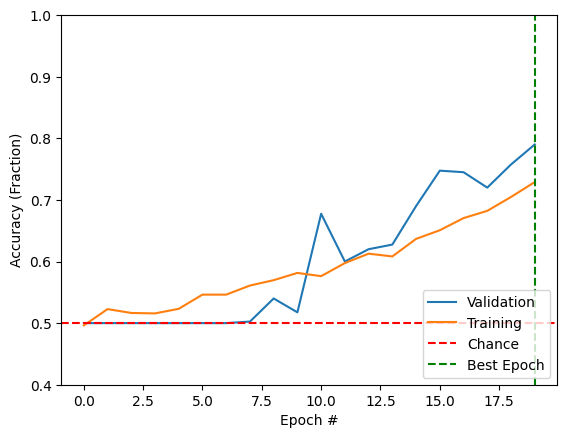

Accuracy:0.78
Epoch 1/20
125/125 [==============================] - 2s 9ms/step - loss: 3.8962 - accuracy: 0.4970 - val_loss: 3.8391 - val_accuracy: 0.5000
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 3.7833 - accuracy: 0.5275 - val_loss: 3.7283 - val_accuracy: 0.5375
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 3.6744 - accuracy: 0.5225 - val_loss: 3.6203 - val_accuracy: 0.7675
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 3.5681 - accuracy: 0.5345 - val_loss: 3.5151 - val_accuracy: 0.7400
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 3.4652 - accuracy: 0.5295 - val_loss: 3.4135 - val_accuracy: 0.5725
Epoch 6/20
125/125 [==============================] - 1s 7ms/step - loss: 3.3642 - accuracy: 0.5343 - val_loss: 3.3139 - val_accuracy: 0.7300
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 3.2658 - accuracy: 0.5493 - val_loss: 3.2173 - val_accuracy:

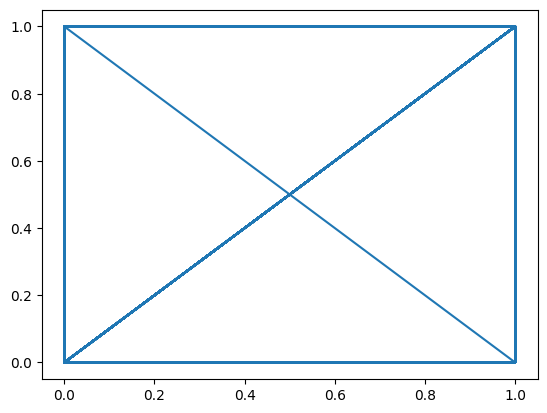

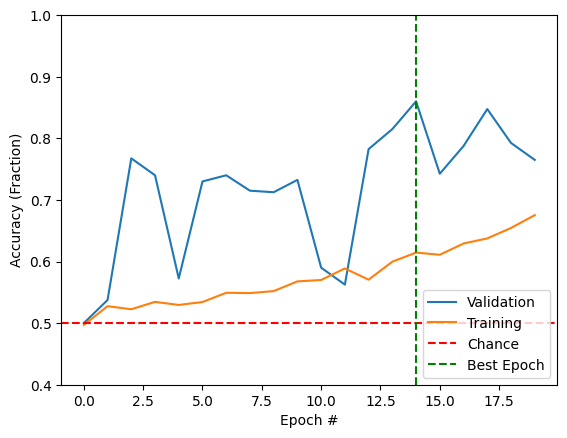

Accuracy:0.74
Epoch 1/20
125/125 [==============================] - 6s 19ms/step - loss: 3.8759 - accuracy: 0.5200 - val_loss: 3.8173 - val_accuracy: 0.5000
Epoch 2/20
125/125 [==============================] - 1s 9ms/step - loss: 3.7611 - accuracy: 0.5163 - val_loss: 3.7023 - val_accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 3.6460 - accuracy: 0.5268 - val_loss: 3.5903 - val_accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 3.5354 - accuracy: 0.5487 - val_loss: 3.4813 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 3.4282 - accuracy: 0.5380 - val_loss: 3.3752 - val_accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 3.3249 - accuracy: 0.5332 - val_loss: 3.2726 - val_accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 3.2238 - accuracy: 0.5455 - val_loss: 3.1724 - val_accuracy

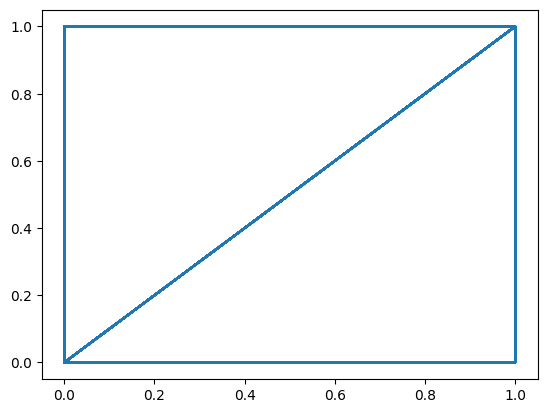

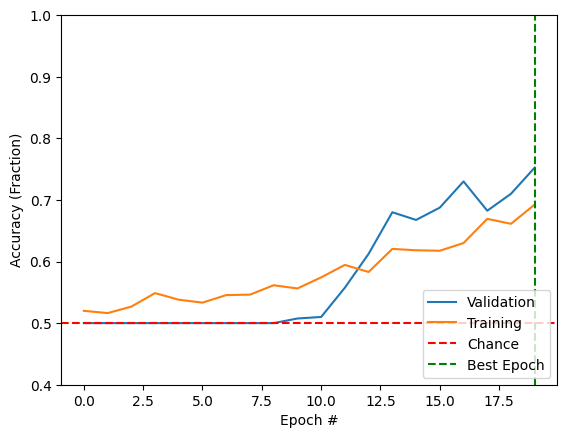

Accuracy:0.76
Epoch 1/20
125/125 [==============================] - 3s 10ms/step - loss: 3.8775 - accuracy: 0.4985 - val_loss: 3.8153 - val_accuracy: 0.5000
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 3.7564 - accuracy: 0.5250 - val_loss: 3.6967 - val_accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 3.6403 - accuracy: 0.5135 - val_loss: 3.5814 - val_accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 3.5264 - accuracy: 0.5307 - val_loss: 3.4694 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 3.4162 - accuracy: 0.5493 - val_loss: 3.3609 - val_accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 3.3093 - accuracy: 0.5490 - val_loss: 3.2555 - val_accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 3.2052 - accuracy: 0.5510 - val_loss: 3.1536 - val_accuracy

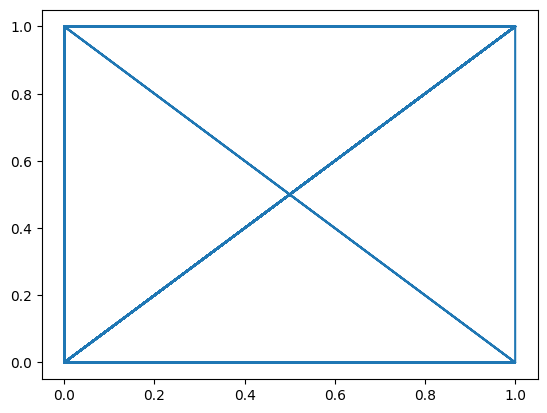

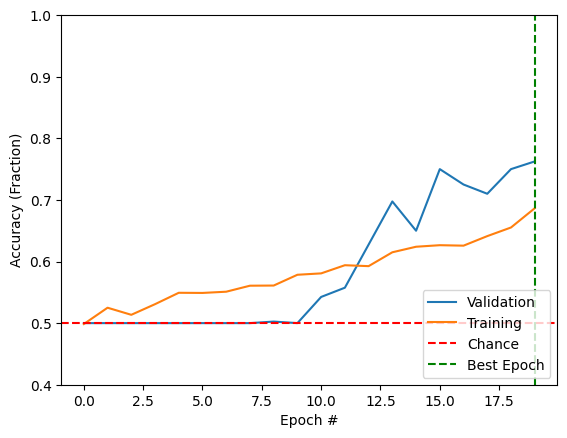

Accuracy:0.79
Epoch 1/20
125/125 [==============================] - 3s 12ms/step - loss: 3.8748 - accuracy: 0.5013 - val_loss: 3.8114 - val_accuracy: 0.5150
Epoch 2/20
125/125 [==============================] - 1s 9ms/step - loss: 3.7507 - accuracy: 0.5010 - val_loss: 3.6898 - val_accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 3.6308 - accuracy: 0.5180 - val_loss: 3.5715 - val_accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 3.5141 - accuracy: 0.5185 - val_loss: 3.4567 - val_accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 3.4009 - accuracy: 0.5268 - val_loss: 3.3454 - val_accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 1s 7ms/step - loss: 3.2910 - accuracy: 0.5253 - val_loss: 3.2371 - val_accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 3.1843 - accuracy: 0.5228 - val_loss: 3.1320 - val_accuracy

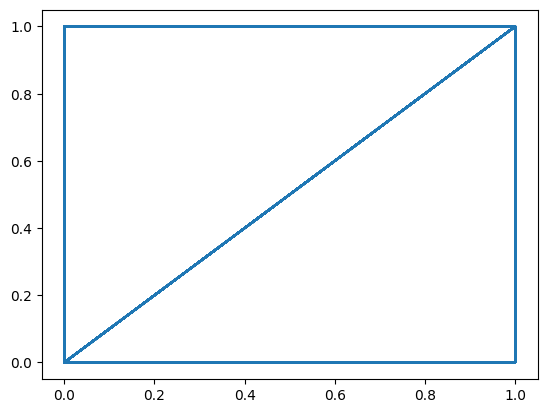

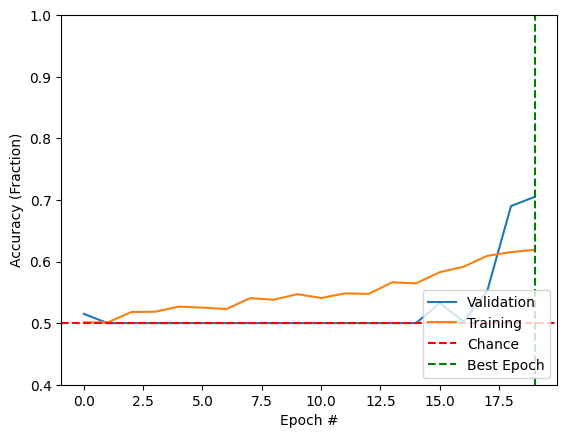

Accuracy:0.73
Average accuracy:  0.7595000000000001


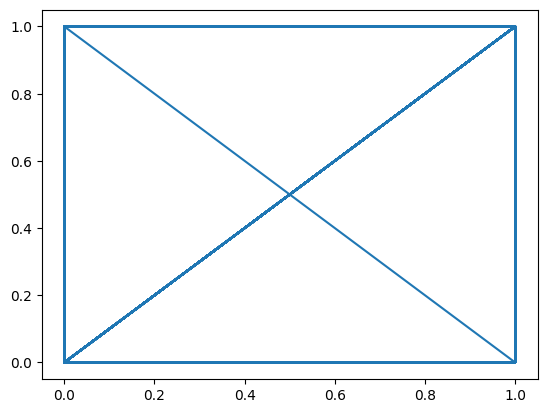

In [24]:
#@title Student Solution

X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()
X_field, y_field   = get_field_data()


### YOUR CODE HERE
average_accuracy = 0.0

for i in range(5):
  cnn = CNNClassifier(5)
  p = cnn.fit(all_data, all_labels, epochs = 20, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
  predictions = (cnn.predict(X_field) > 0.5)
  plot_acc(p)
  plt.plot(predictions, y_field)
  accuracy = accuracy_score(y_field, predictions)
  print('Accuracy:%0.2f'%accuracy)
  average_accuracy += accuracy

average_accuracy /= 5

print('Average accuracy: ', average_accuracy)

### END CODE

## Instructor-Led Discussion: Why does data augmentation improve average performance?

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

##Congratulations on completing your model!

By augmenting your data, you've (hopefully) gotten your models working better, even on messy field data!

As a further challenge, you can return to any point in the challenge and try to improve:
- Try looking at the CNN code in the hidden cell at the top. Can you change the parameters to reduce overfitting?
- Try out different classifiers from Scikit-learn with augmented data.
- Create new combinations of augmentations for your data.
- Whatever ideas you come up with!